# Infer Pooled Model Parameters from Individuals in Lung Cancer Control Group

## Show control group data

In [1]:
import erlotinib as erlo

# Get data
data = erlo.DataLibrary().lung_cancer_control_group()

# Create scatter plot
fig = erlo.plots.PDTimeSeriesPlot()
fig.add_data(data, biomarker='Tumour volume')
fig.set_axis_labels(xlabel=r'$\text{Time in day}$', ylabel=r'$\text{Tumour volume in cm}^3$')

# Show figure
fig.show()

**Figure 1:** Visualisation of the measured tumour growth in 8 mice with patient-derived lung cancer implants.

## Visualise posterior distribution

In [2]:
import xarray as xr

# Import posterior
path = os.getcwd()
posterior = xr.open_dataset(path + '/posteriors/pooled.nc')

# Plot marginal posteriors
fig = erlo.plots.MarginalPosteriorPlot()
fig.add_data(data=posterior)

fig.show()

**Figure 3:** Marginal posterior distributions of model parameters. The y axis displays the sampled parameter value, and the x axis the binned number of samples.

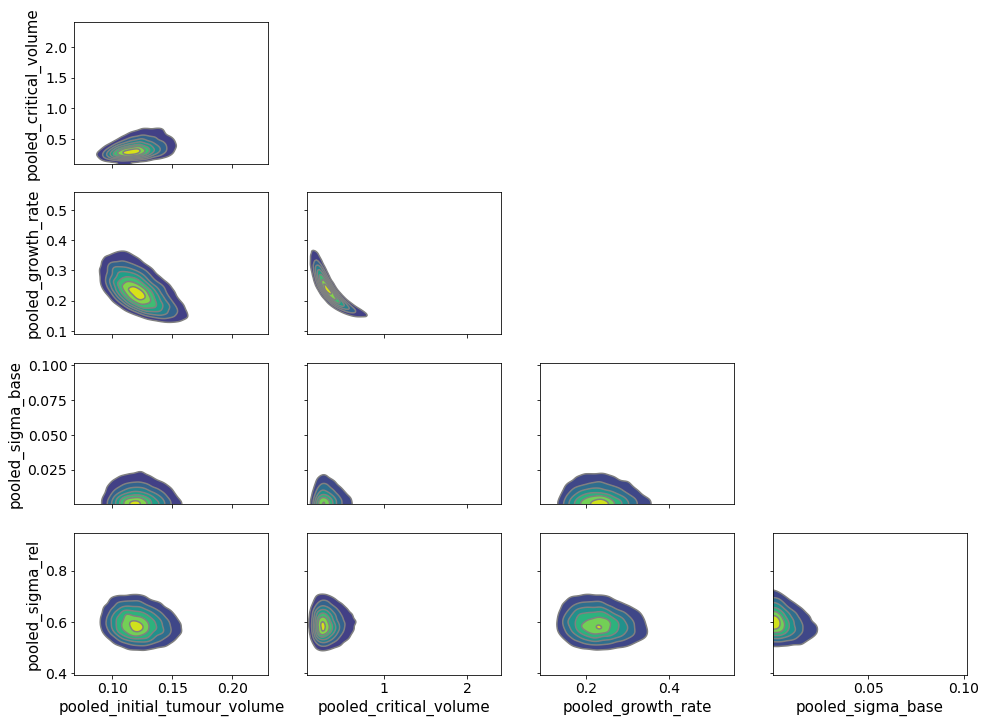

In [9]:
import arviz as az
import matplotlib.pyplot as plt

az.plot_pair(posterior, kind='kde', figsize=(16, 12))
plt.show()

**Figure 4:** 2 dimensional marginal posterior distributions of model parameters. The x and y axis represent values of different model parameters and the colouring indicate low (blue) to high (yellow) probability mass.

## Build model

In [2]:
# Define mechanistic model
path = erlo.ModelLibrary().tumour_growth_inhibition_model_koch_reparametrised()
mechanistic_model = erlo.PharmacodynamicModel(path)
mechanistic_model.set_parameter_names(names={
    'myokit.tumour_volume': 'Tumour volume in cm^3',
    'myokit.critical_volume': 'Critical volume in cm^3',
    'myokit.drug_concentration': 'Drug concentration in mg/L',
    'myokit.kappa': 'Potency in L/mg/day',
    'myokit.lambda': 'Exponential growth rate in 1/day'})

# Define error model
error_model = erlo.ConstantAndMultiplicativeGaussianErrorModel()

# Define population model
population_models = [
    erlo.PooledModel(),  # Initial tumour volume
    erlo.PooledModel(),  # Critical volume
    erlo.PooledModel(),  # Growth rate
    erlo.PooledModel(),  # Sigma base
    erlo.PooledModel()]  # Sigma rel.

# Compose model and not identified parameters
problem = erlo.ProblemModellingController(mechanistic_model, error_model)
problem.fix_parameters({
    'Drug concentration in mg/L': 0,
    'Potency in L/mg/day': 0})
problem.set_population_model(population_models)

### Visualise posterior predictive distribution

In [6]:
import os
import numpy as np
import xarray as xr

# Define posterior predictive model
predictive_model = problem.get_predictive_model()
param_map = {
    'Pooled Tumour volume in cm^3': 'pooled_initial_tumour_volume',
    'Pooled Critical volume in cm^3': 'pooled_critical_volume',
    'Pooled Exponential growth rate in 1/day': 'pooled_growth_rate',
    'Pooled Sigma base': 'pooled_sigma_base',
    'Pooled Sigma rel.': 'pooled_sigma_rel'}
posterior_predictive_model = erlo.PosteriorPredictiveModel(
    predictive_model, posterior, param_map)

# Sample from posterior predictive model
times = np.linspace(0, 30)
n_samples = 200
samples = posterior_predictive_model.sample(times, n_samples)

# Visualise posterior predictive distributions
fig = erlo.plots.PDPredictivePlot()
fig.add_prediction(data=samples)
fig.add_data(data, biomarker='Tumour volume')
fig.set_axis_labels(xlabel=r'$\text{Time in day}$', ylabel=r'$\text{Tumour volume in cm}^3$')
fig.show()